**ARIMA** (AutoRegressive Integrated Moving Average):
- Components: ARIMA models consist of three main components: Autoregressive (AR) terms, Integrated (I) terms, and Moving Average (MA) terms.
- Manual Selection: In a traditional ARIMA approach, you manually select the order of the AR, I, and MA components based on analysis of the autocorrelation and partial autocorrelation plots, as well as stationarity tests.
- Usage: ARIMA is a powerful and flexible method, but choosing the right orders can be challenging, especially for users without extensive time series expertise.
Auto-ARIMA:

**Automated Parameter Selection**: Auto-ARIMA, on the other hand, automates the process of selecting the order of the ARIMA model.
- Search Algorithm: Auto-ARIMA typically employs a search algorithm that explores different combinations of AR, I, and MA orders to find the model with the lowest Akaike Information Criterion (AIC) or Bayesian Information Criterion (BIC).
- Ease of Use: Auto-ARIMA is user-friendly and requires less manual intervention compared to traditional ARIMA. It is suitable for users who are less familiar with time series analysis.

# ARIMA

ARIMA(p,d,q) 
- p: The number of lag observations included in the model, also called the lag order.
- d: The number of times that the raw observations are differenced, also called the degree of differencing.
- q: The size of the moving average window, also called the order of moving average.

- AR term refers to the past values used for forecasting the next value. The AR term is defined by the parameter ‘p’ in arima. The value of ‘p’ is determined using the PACF plot.

- MA term is used to defines number of past forecast errors used to predict the future values. The parameter ‘q’ in arima represents the MA term. ACF plot is used to identify the correct ‘q’ value.

- Order of differencing  specifies the number of times the differencing operation is performed on series to make it stationary. Test like ADF and KPSS can be used to determine whether the series is stationary and help in identifying the d value.

In [1]:
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import warnings
# Suppress all warnings
warnings.simplefilter("ignore")

/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# import data
df = pd.read_csv('df_post_eda.csv')

In [3]:
pred_var = 'Additional_Doses_Vax_Pct'
df['Date'] = pd.to_datetime(df['Date'])
df = df.groupby('Date')[pred_var].mean()
df = pd.DataFrame(df)
df.head()

,Additional_Doses_Vax_Pct
Date,
2021-11-03,10.332812
2021-11-10,13.185937
2021-11-17,15.871875
2021-11-24,18.675000
2021-12-01,20.689062


In [4]:
# Scale data -> some % columns, some raw number columns
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns, index=df.index)
df_scaled.head(3)

,Additional_Doses_Vax_Pct
Date,
2021-11-03,0.000000
2021-11-10,0.070026
2021-11-17,0.135949


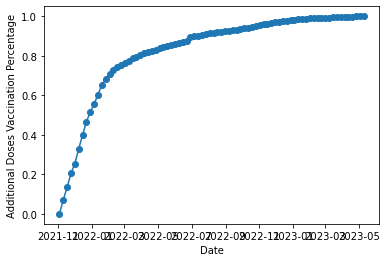

In [5]:
plt.plot(df_scaled.index, df_scaled['Additional_Doses_Vax_Pct'], marker='o', linestyle='-')
plt.xlabel('Date')
plt.ylabel('Additional Doses Vaccination Percentage')
plt.show()

### Stationary Test

- Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
- Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure

- p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
- p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [6]:
# Time series are stationary if they do not have trend or seasonal effects. 
#Summary statistics calculated on the time series are consistent over time, 
# like the mean or the variance of the observations.

from statsmodels.tsa.stattools import adfuller

X = df_scaled.values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
 print('\t%s: %.3f' % (key, value))

ADF Statistic: -4.009253
p-value: 0.001363
Critical Values:
	1%: -3.518
	5%: -2.900
	10%: -2.587


In [7]:
# try different test 
from statsmodels.tsa.stattools import kpss

# Sample time series data (replace this with your own data)
data = df_scaled

# KPSS test
result = kpss(data, regression='c')  # 'c' for constant, 'ct' for constant with trend

# Extract test statistic and p-value 
test_statistic = result[0]
p_value = result[1]

# Compare with critical value at a chosen significance level
critical_value = 0.05  # adjust as needed
print(f"Test Statistic: {test_statistic}")
print(f"P-value: {p_value}")
print(f"Critical Value at 5% Significance Level: {critical_value}")

# Check the result
if test_statistic > critical_value:
    print("Reject the null hypothesis: Data is not stationary around a deterministic trend.")
else:
    print("Fail to reject the null hypothesis: Data is stationary around a deterministic trend.")

Test Statistic: 1.0632874725225505
P-value: 0.01
Critical Value at 5% Significance Level: 0.05
Reject the null hypothesis: Data is not stationary around a deterministic trend.


KPSS Test:
Useful when you suspect the non-stationarity is due to a deterministic trend.
ADF Test:
Useful when you suspect the non-stationarity is due to a stochastic trend.

Our data seems to be more deterministic. Our data also seems to follow non-stationarity, as it has an increasing trend and the mean does not remain constant over time. Our ACF graph also supports our data being non-stationary, as in stationary data, the ACF plot typically shows a rapid decay in autocorrelation as the lag increases. Our ACF graph shows a slow decline in autocorrelation as the lag increases. Thus, our data is non-stationary.

### Autocorrelation Test

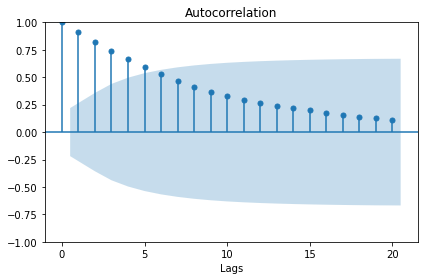

In [8]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
alpha=0.05
# Select a multiple of the seasonal frequency for the number of lags
plot_acf(df_scaled[pred_var])
plt.xlabel('Lags')
plt.tight_layout()

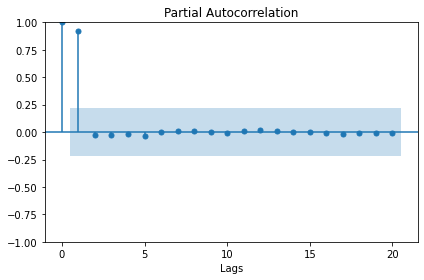

In [9]:
plot_pacf(df_scaled[pred_var])
plt.xlabel('Lags')
plt.tight_layout()
plt.show()

In [10]:
# most significant at is 1st lag. consider "p" to be 1

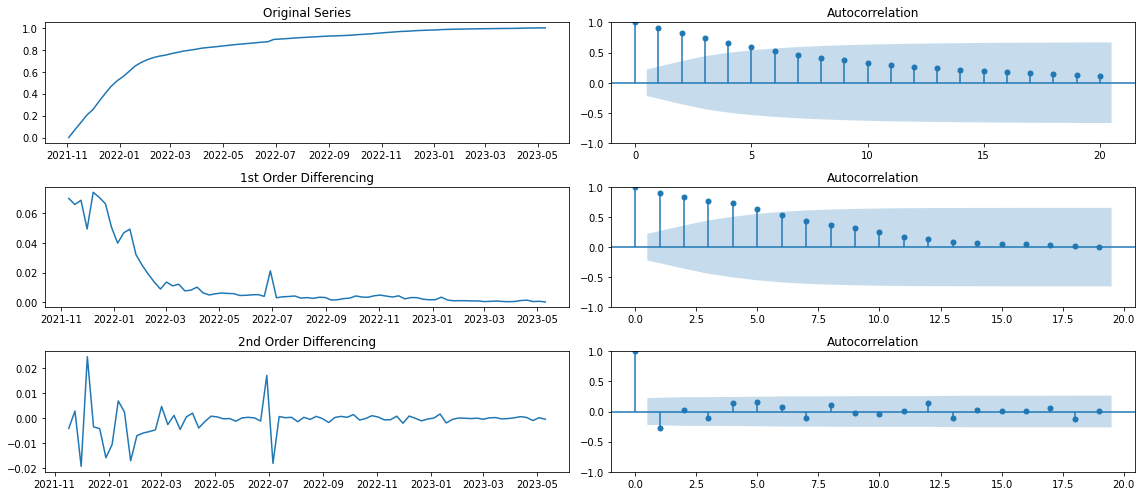

In [11]:
# Original Series
fig, axes = plt.subplots(3, 2, figsize=(16, 7))

axes[0, 0].plot(df_scaled.index, df_scaled.values)
axes[0, 0].set_title('Original Series')
plot_acf(df_scaled, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df_scaled.index, df_scaled.diff().values)
axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_scaled.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df_scaled.index, df_scaled.diff().diff().values)
axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_scaled.diff().diff().dropna(), ax=axes[2, 1])

plt.tight_layout()
plt.show()

In [12]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_scaled[pred_var])
print('p-value:', result[1])

result = adfuller(df_scaled[pred_var].diff().dropna())
print('p-value:', result[1])

result = adfuller(df_scaled[pred_var].diff().diff().dropna())
print('p-value:', result[1])

result = adfuller(df_scaled[pred_var].diff().diff().diff().dropna())
print('p-value:', result[1])

p-value: 0.0013628258781567357
p-value: 0.0052358326581608905
p-value: 3.1813811354700045e-21
p-value: 7.021575729809569e-10


In [ ]:
# at d=1, see that data goes from stationary to non-stationary, but back to stationary for d>2
# start with d=2

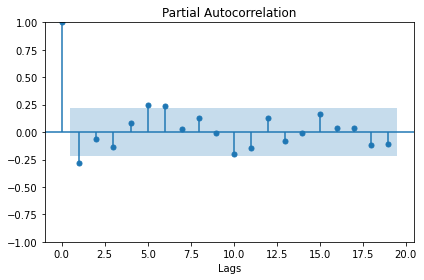

In [9]:
plot_pacf(df_scaled[pred_var])
plt.xlabel('Lags')
plt.tight_layout()
plt.show()

### Base ARIMA Model

In [13]:
# Splitting data into Train and Test -> test is from start of 2023 and beyond

split_date = '2023-01-03'

train = df_scaled[df_scaled.index < split_date]
test = df_scaled[df_scaled.index >= split_date]

print(train.shape, test.shape) # 70-30 train split

(61, 1) (19, 1)


In [14]:
# Fit an ARIMA model on the training data
order = (1, 2, 1)  # Initial, Lag=1
model = ARIMA(train, order = order)
fit_model = model.fit()

# Make predictions on the training and testing sets
train_pred = fit_model.fittedvalues
test_pred = fit_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)

# Calculate RMSE for training set
train_rmse = sqrt(mean_squared_error(train, train_pred))

# Calculate RMSE for testing set
test_rmse = sqrt(mean_squared_error(test, test_pred))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

Training RMSE: 0.010979441074263688
Testing RMSE: 0.008051874807460044


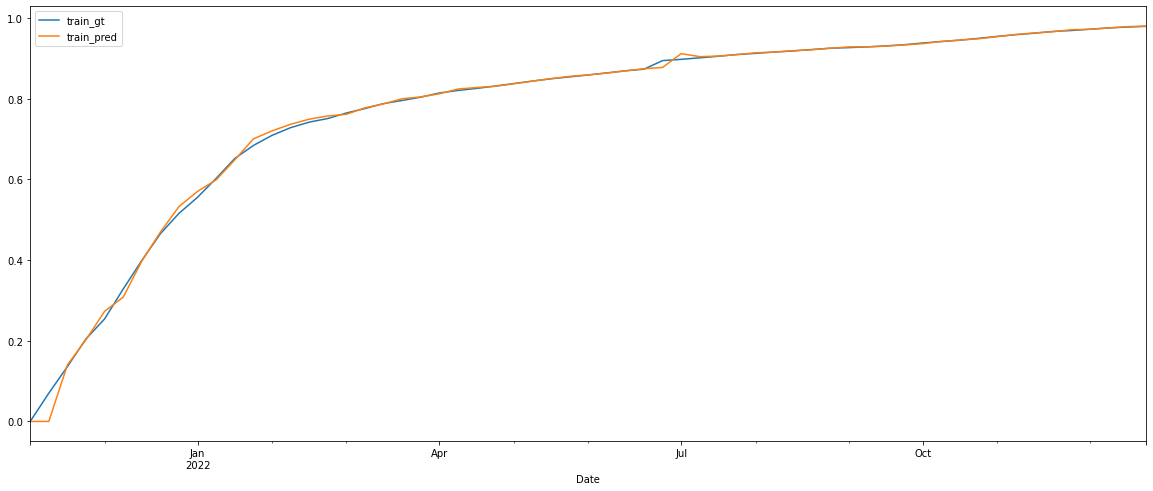

In [15]:
pd.concat([train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])

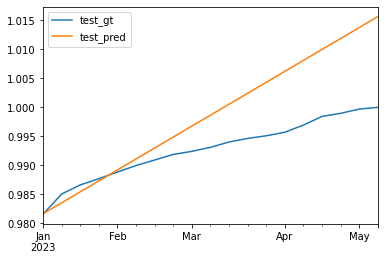

In [16]:
pd.concat([test, test_pred], axis=1).plot()
plt.legend(['test_gt', 'test_pred'])

### Tuning ARIMA Model

In [18]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from math import sqrt

# Split the data into training and testing sets
train_size = int(len(df_scaled) * 0.7625)
train, test = df_scaled[:train_size], df_scaled[train_size:]

# Define the range of hyperparameters for the grid search
p_values = range(0, 6)
d_values = [2]
q_values = range(0, 6)

# Perform time series cross-validation with sklearn TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size = 4, gap = 3)  # Adjust the number of splits as needed
best_test_rmse = float('inf')
best_order = None

# Grid search through ARIMA hyperparameters
for p in p_values:
    for d in d_values:
        for q in q_values:
            test_rmse_values = []

            for train_index, test_index in tscv.split(train):
                train_fold, test_fold = train.iloc[train_index], train.iloc[test_index]

                # Train ARIMA model
                model = ARIMA(train_fold, order=(p, d, q))
                fit_model = model.fit()

                # Make predictions on the test fold
                test_fold_pred = fit_model.predict(start=len(train_fold), end=len(train_fold)+len(test_fold)-1, dynamic=True)

                # Calculate RMSE for the test fold
                test_fold_rmse = sqrt(mean_squared_error(test_fold, test_fold_pred))
                test_rmse_values.append(test_fold_rmse)

            # Calculate average test RMSE across cross-validation folds
            avg_test_rmse = np.mean(test_rmse_values)

            # Update best order if current combination has lower average test RMSE
            if avg_test_rmse < best_test_rmse:
                best_test_rmse = avg_test_rmse
                best_order = (p, d, q)

print(f"Best ARIMA Order: {best_order}")
print(f"Lowest Average Test RMSE: {best_test_rmse}")

Best ARIMA Order: (4, 2, 5)
Lowest Average Test RMSE: 0.0071218884147374924


In [19]:
# Fit an ARIMA model on the training data
order = (4, 2, 5) 
model = ARIMA(train, order = order)
fit_model = model.fit()

# Make predictions on the training and testing sets
train_pred = fit_model.fittedvalues
test_pred = fit_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)

# Calculate RMSE for training set
train_rmse = sqrt(mean_squared_error(train, train_pred))

# Calculate RMSE for testing set
test_rmse = sqrt(mean_squared_error(test, test_pred))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

Training RMSE: 0.010757151172069187
Testing RMSE: 0.00762629769328813


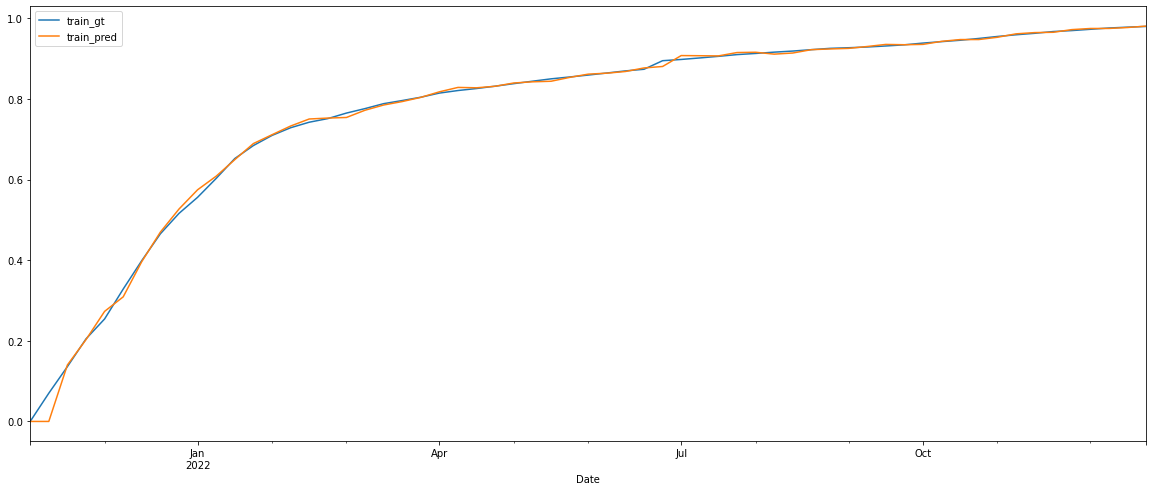

In [20]:
pd.concat([train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])

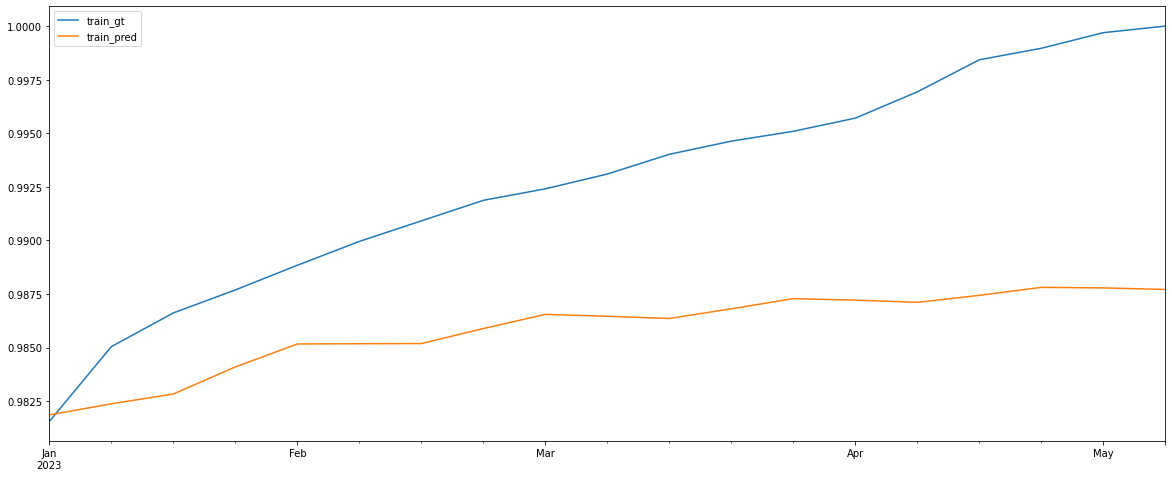

In [21]:
pd.concat([test, test_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train_gt', 'train_pred'])

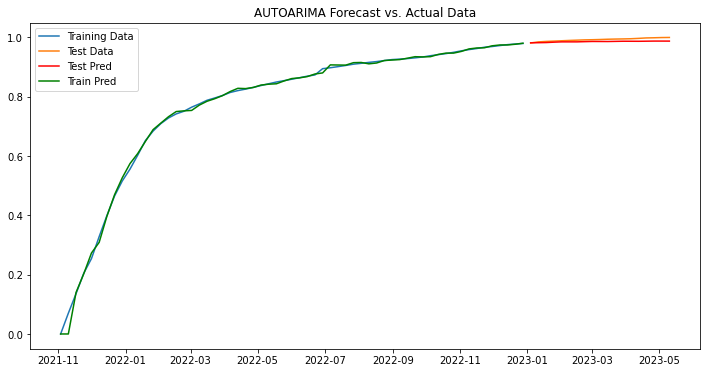

In [22]:
# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(test.index, test_pred, label='Test Pred', color='red')
plt.plot(train.index, train_pred, label='Train Pred', color='green')
plt.legend()
plt.title('AUTOARIMA Forecast vs. Actual Data')
plt.show()

In [24]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from math import sqrt

# Split the data into training and testing sets
train_size = int(len(df_scaled) * 0.7625)
train, test = df_scaled[:train_size], df_scaled[train_size:]

# Define the range of hyperparameters for the grid search
p_values = range(0, 6)
d_values = range(2, 6)
q_values = range(0, 6)

# Perform time series cross-validation with sklearn TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size = 4, gap = 3)  # Adjust the number of splits as needed
best_test_rmse = float('inf')
best_order = None

# Grid search through ARIMA hyperparameters
for p in p_values:
    for d in d_values:
        for q in q_values:
            test_rmse_values = []

            for train_index, test_index in tscv.split(train):
                train_fold, test_fold = train.iloc[train_index], train.iloc[test_index]

                # Train ARIMA model
                model = ARIMA(train_fold, order=(p, d, q))
                fit_model = model.fit()

                # Make predictions on the test fold
                test_fold_pred = fit_model.predict(start=len(train_fold), end=len(train_fold)+len(test_fold)-1, dynamic=True)

                # Calculate RMSE for the test fold
                test_fold_rmse = sqrt(mean_squared_error(test_fold, test_fold_pred))
                test_rmse_values.append(test_fold_rmse)

            # Calculate average test RMSE across cross-validation folds
            avg_test_rmse = np.mean(test_rmse_values)

            # Update best order if current combination has lower average test RMSE
            if avg_test_rmse < best_test_rmse:
                best_test_rmse = avg_test_rmse
                best_order = (p, d, q)

print(f"Best ARIMA Order: {best_order}")
print(f"Lowest Average Test RMSE: {best_test_rmse}")

Best ARIMA Order: (4, 2, 5)
Lowest Average Test RMSE: 0.0071218884147374924


In [25]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from math import sqrt

# Split the data into training and testing sets
train_size = int(len(df_scaled) * 0.7625)
train, test = df_scaled[:train_size], df_scaled[train_size:]

# Define the range of hyperparameters for the grid search
p_values = [1]
d_values =[2]
q_values = [0, 1, 2, 3, 4, 5]

# Perform time series cross-validation with sklearn TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5, test_size = 4, gap = 3)  # Adjust the number of splits as needed
best_test_rmse = float('inf')
best_order = None

# Grid search through ARIMA hyperparameters
for p in p_values:
    for d in d_values:
        for q in q_values:
            test_rmse_values = []

            for train_index, test_index in tscv.split(train):
                train_fold, test_fold = train.iloc[train_index], train.iloc[test_index]

                # Train ARIMA model
                model = ARIMA(train_fold, order=(p, d, q))
                fit_model = model.fit()

                # Make predictions on the test fold
                test_fold_pred = fit_model.predict(start=len(train_fold), end=len(train_fold)+len(test_fold)-1, dynamic=True)

                # Calculate RMSE for the test fold
                test_fold_rmse = sqrt(mean_squared_error(test_fold, test_fold_pred))
                test_rmse_values.append(test_fold_rmse)

            # Calculate average test RMSE across cross-validation folds
            avg_test_rmse = np.mean(test_rmse_values)

            # Update best order if current combination has lower average test RMSE
            if avg_test_rmse < best_test_rmse:
                best_test_rmse = avg_test_rmse
                best_order = (p, d, q)

print(f"Best ARIMA Order: {best_order}")
print(f"Lowest Average Test RMSE: {best_test_rmse}")

Best ARIMA Order: (1, 2, 4)
Lowest Average Test RMSE: 0.009003617936057773


In [29]:
order = (1, 2, 4)  # Initial, Lag=1
model = ARIMA(train, order = order)
fit_model = model.fit()

# Make predictions on the training and testing sets
train_pred = fit_model.fittedvalues
test_pred = fit_model.predict(start=len(train), end=len(train)+len(test)-1, dynamic=True)

# Calculate RMSE for training set
train_rmse = sqrt(mean_squared_error(train, train_pred))

# Calculate RMSE for testing set
test_rmse = sqrt(mean_squared_error(test, test_pred))

print(f"Training RMSE: {train_rmse}")
print(f"Testing RMSE: {test_rmse}")

Training RMSE: 0.010801980549264008
Testing RMSE: 0.00693365638067238


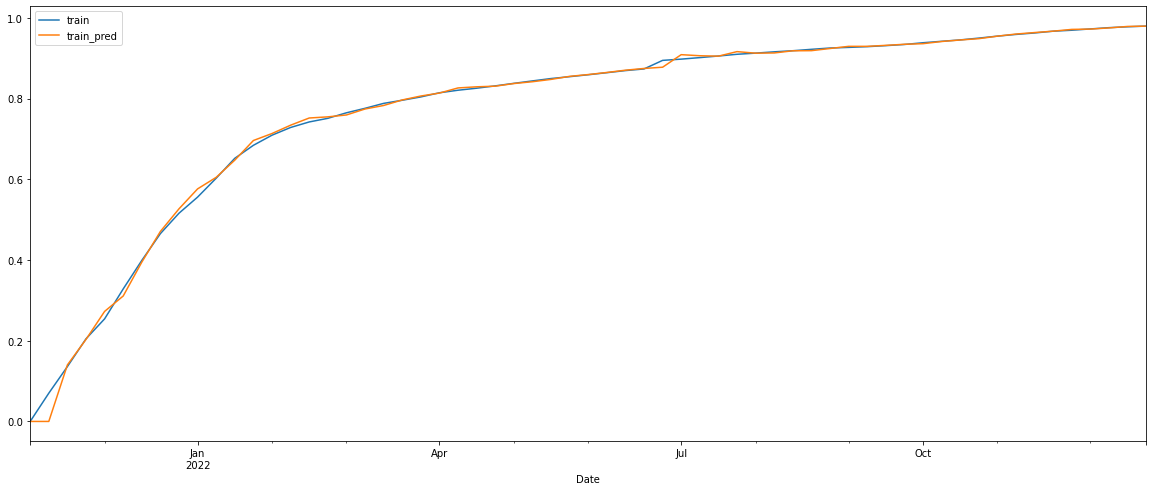

In [30]:
pd.concat([train, train_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['train', 'train_pred'])

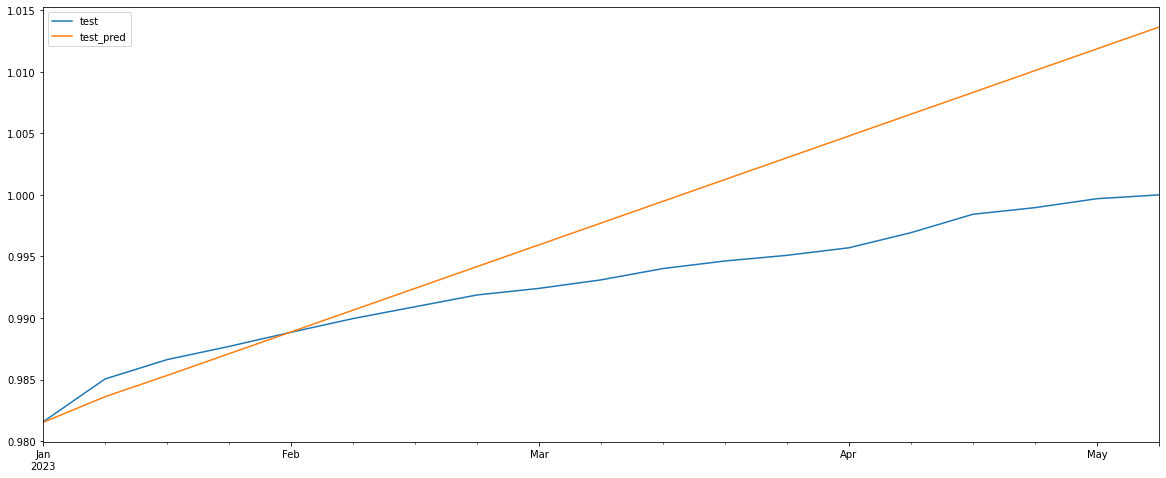

In [31]:
pd.concat([test, test_pred], axis=1).plot(figsize=(20, 8))
plt.legend(['test', 'test_pred'])

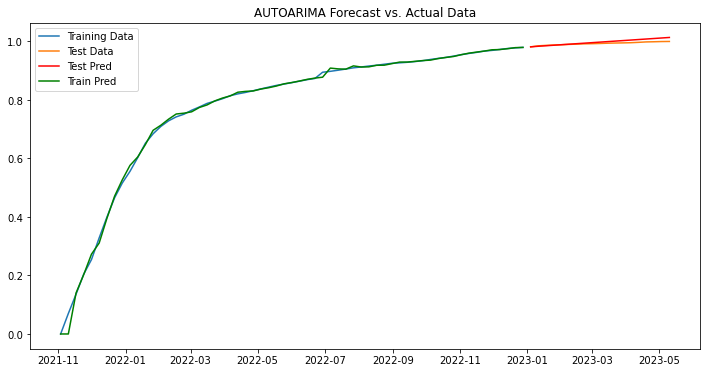

In [32]:
# Plot the actual vs. forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train, label='Training Data')
plt.plot(test, label='Test Data')
plt.plot(test.index, test_pred, label='Test Pred', color='red')
plt.plot(train.index, train_pred, label='Train Pred', color='green')
plt.legend()
plt.title('AUTOARIMA Forecast vs. Actual Data')
plt.show()

### Final Best Model: (1,2,4)